# Overview of Discrete 3D Data

We're going to talk about a couple different ways of getting overviews of 3D data that is stored discretely.

For this, we'll use some "real" data from a galaxy simulation, accessible on the yt-project [sample data page](https://yt-project.org/data/).  Go ahead and download [Gadget Disk Galaxy](http://yt-project.org/data/GadgetDiskGalaxy.tar.gz) and extract it.

 * Scatter plots and their problems
 * Summarization of discrete data
 * Computing neighbor information
 * Really large sets of particles
 * Binning, hexbinning, and smoothing

In [1]:
!wget --no-clobber http://yt-project.org/data/GadgetDiskGalaxy.tar.gz && tar xvfz GadgetDiskGalaxy.tar.gz

--2021-02-12 09:13:05--  http://yt-project.org/data/GadgetDiskGalaxy.tar.gz
Resolving yt-project.org (yt-project.org)... 208.113.222.15
Connecting to yt-project.org (yt-project.org)|208.113.222.15|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://yt-project.org/data/GadgetDiskGalaxy.tar.gz [following]
--2021-02-12 09:13:06--  https://yt-project.org/data/GadgetDiskGalaxy.tar.gz
Connecting to yt-project.org (yt-project.org)|208.113.222.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452350916 (431M) [application/gzip]
Saving to: ‘GadgetDiskGalaxy.tar.gz’

GadgetDiskGalaxy.ta 100%[===================>] 431.39M  37.2MB/s    in 14s     

2021-02-12 09:13:20 (30.4 MB/s) - ‘GadgetDiskGalaxy.tar.gz’ saved [452350916/452350916]

x GadgetDiskGalaxy/
x GadgetDiskGalaxy/load.py
x GadgetDiskGalaxy/snapshot_200.hdf5


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcm
import ipywidgets
import pythreejs
plt.rcParams["figure.dpi"] = 200

Now, we're going to open it using h5py and load in a handful of fields.

In [3]:
part_dm = {}
part_gas = {}
with h5py.File("GadgetDiskGalaxy/snapshot_200.hdf5", "r") as f:
    part_gas["Coordinates"] = f["/PartType0/Coordinates"][()]
    part_gas["Masses"] = f["/PartType0/Masses"][()]
    part_gas["Density"] = f["/PartType0/Density"][()]
    part_gas["Velocities"] = f["/PartType0/Velocities"][()]
    part_gas["SmoothingLength"] = f["/PartType0/SmoothingLength"][()]
    part_dm["Coordinates"] = f["/PartType1/Coordinates"][()]
    part_dm["Velocities"] = f["/PartType1/Velocities"][()]

Our first order of business: let's try making a density plot!  There are, as you can probably tell, far too many particles to simply make a scatter plot.  So let's try hexbinning the data.

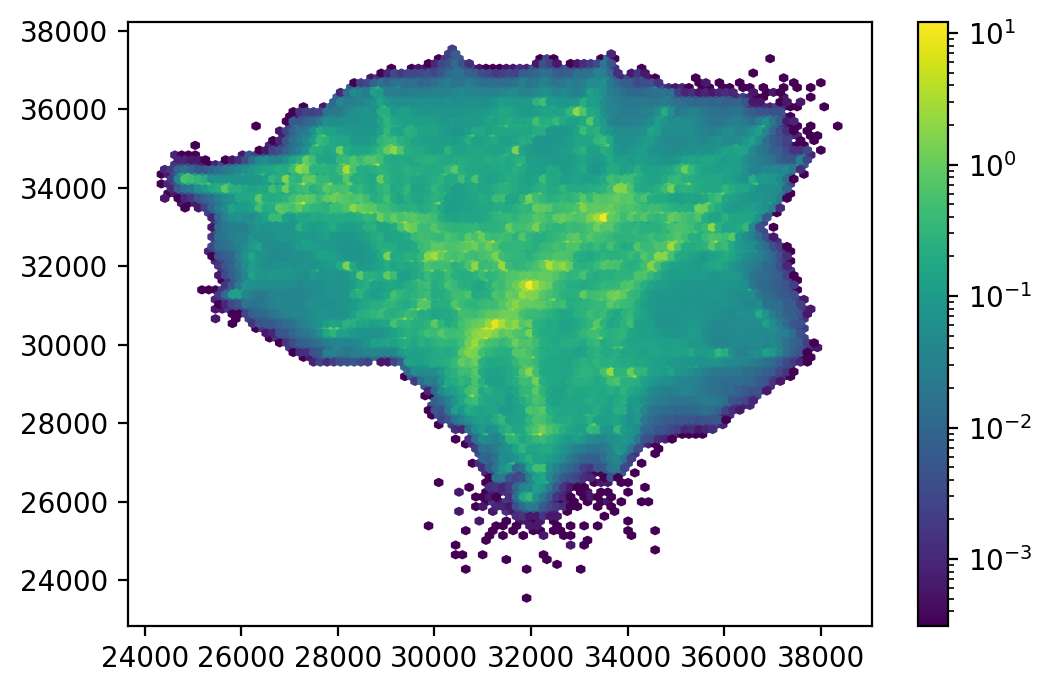

In [4]:
plt.hexbin(part_gas["Coordinates"][:,0], part_gas["Coordinates"][:,1], part_gas["Masses"], reduce_C_function=np.sum, norm=mcm.LogNorm())
plt.colorbar()

And we're left with what seems to be a rather servicable distribution of projected mass.  There are a few artifacts we need to clean up, especially including our units (which I will forego) but also the slight overlapping of the hexagonal bins.  We can turn that off by making our edge lines a bit smaller.

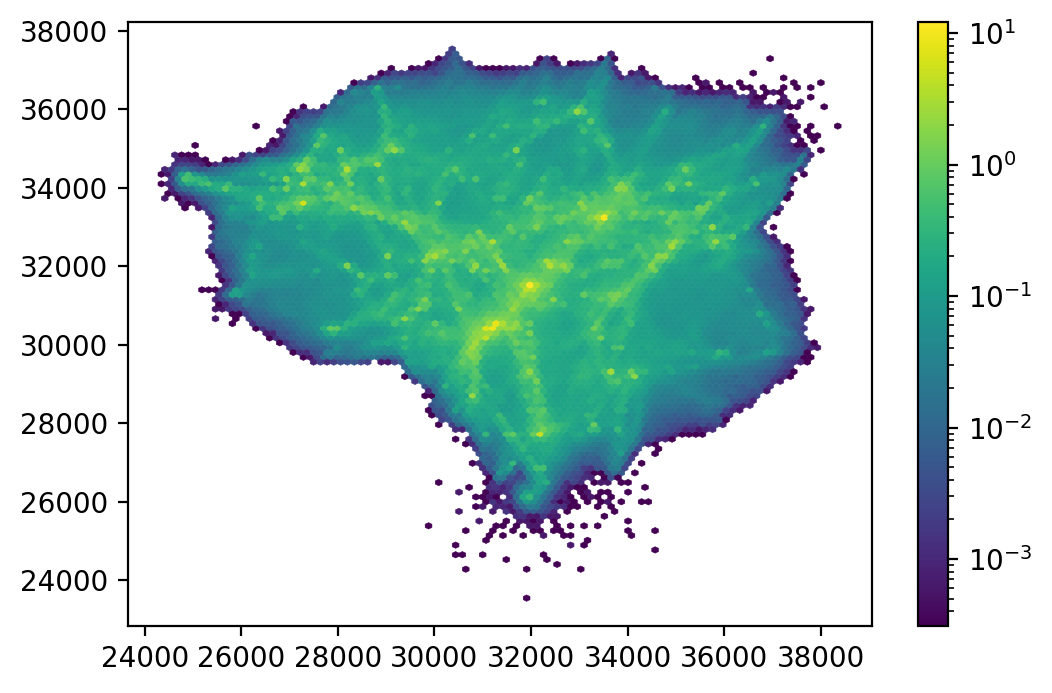

In [5]:
plt.hexbin(part_gas["Coordinates"][:,0], part_gas["Coordinates"][:,1], part_gas["Masses"], reduce_C_function=np.sum, norm=mcm.LogNorm(), linewidth=0.2)
plt.colorbar()



We won't duplicate here the process of making these images from different axis-aligned angles, like we did with the regular mesh data.  Instead, let's take a look at how we might apply some changes thaUnfortunately, getting the edges exactly right [is kind of a hard thing](https://github.com/matplotlib/matplotlib/issues/7311) so it's going to require a bit of work and fiddling.

With discrete data, unfortunately, it can be quite difficult to get the visualizations of extended particles exactly right.  There's a fair bit of formalism that goes into Lagrangian hydrodynamics, and often it is formulated with Smoothed Particle Hydrodynamics (SPH).  In SPH, the particles are sampling points of a function, but they have extended influence 

$${\displaystyle A({\boldsymbol {r}})=\int A\left({\boldsymbol {r^{\prime }}}\right)W(|{\boldsymbol {r}}-{\boldsymbol {r^{\prime }}}|,h)\mathrm {d} V\left({\boldsymbol {r^{\prime }}}\right)}$$

Usually this is done with a kernel that cuts off at some point, to avoid convolving over the entire domain.  The mechanisms by which smoothing kernels are defined take a couple different forms, including strict cutoffs at a given number of particles, an iterative calculation of the number of nearest neighbors to compute, and with different radius-dependent functions to define contributions.  You'll usually see it written in some form of:

$${\displaystyle A({\boldsymbol {r}})=\sum _{j}V_{j}A_{j}W(|{\boldsymbol {r}}-{\boldsymbol {r}}_{j}|,h)}$$

In this case, $V_{j}$ is the volume, which we usually rewrite as the mass divided by the density.  (You might have noticed above that we loaded both the masses and the densities for our gas particles.)

A proper course on SPH would go into considerable detail about the choices of smoothing kernels, but for our purposes we will use the smoothing length loaded from the file, along with a cubic spline kernel; keep in mind that different locations define the smoothing length differently, as half-length or full-length.  You can find a good amount of detail on formalism about visualizing SPH particles in Daniel Price's [paper about SPLASH](https://arxiv.org/abs/0709.0832v1).  The cubic spline kernel is defined (where is radius over smoothing *half*-length, $q \equiv |\mathbf{r}|/h$ and $\nu$ is the number of dimensions, so 3 in our case) as:

$$
f(x) = \frac{\sigma}{h^\nu}\begin{cases} 
1 - \frac{3}{2}q^2 + \frac{3}{4}q^3 & 0 \leq q < 1 \\
\frac{1}{4}(2-q)^3 & 1 \leq q < 2 \\
0 & q \geq 2
\end{cases}
$$

In equation 11 of that paper, Price has an elegant derivation of the deposition of values into pixels in a given image, where the impact parameter is taken into account.  This is useful for slicing through the dataset, and equation 32 is the appropriate function to use for projecting through a dataset.

**NOTE**: It should be very clear by this point that figuring out the distances to particles, and figuring out which particles are close to a given point, is going to be crucial to making sure that we can visualize things quickly!  We're going to mostly sidestep that issue and outsource it either to the [scipy.spatial](https://docs.scipy.org/doc/scipy/reference/spatial.html) module or specialized tools like [pynbody](https://pynbody.github.io/pynbody/) and [yt](https://yt-project.org/).

This will be explored in one of the problems.

## Rotation

We won't duplicate here the process of making these images from different axis-aligned angles, like we did with the regular mesh data.  Instead, let's take a look at how we might apply some changes that are unique to discrete data.  We instead will focus on rotations.  The Wikipedia page on [rotations in three dimensions](https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions) is helpful and likely somewhat easier to get started with, but the more useful set of operations in the long-term is likely [quaternions](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).  Quaternions avoid singularities you might run into when rotating.

We'll use quaternions in the problem section, but for now we'll use [Davenport chained rotations](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation).  We'll apply yaw-pitch-roll, or YPR rotations.  This means our final matrix which we'll multiply our coordinates by will be defined as:

$$M = R_z(\psi)R_y(\theta)R_x(\phi)$$

with the definitions of the matrices as:

$$
R_x(\phi) = \left[
\begin{matrix}
1 & 0 & 0 \\
0 & \cos\phi & -\sin\phi \\
0 & \sin\phi & \cos\phi
\end{matrix}
\right] ;
R_y(\theta) = \left[
\begin{matrix}
\cos\theta & 0 & \sin\theta \\
0 & 1 & 0 \\
-\sin\theta & 0 & \cos\theta
\end{matrix}
\right] ;
R_z(\psi) = \left[
\begin{matrix}
\cos\psi & -\sin\psi & 0 \\
\sin\psi & \cos\psi & 0 \\
0 & 0 & 1
\end{matrix}
\right]
$$

So, let's write a function to take these three angles and return a combined $M$ matrix that we can multiply by.

In [6]:
def rotation_matrix(phi, theta, psi):
    s_phi, c_phi = np.sin(phi), np.cos(phi)
    s_theta, c_theta = np.sin(theta), np.cos(theta)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    Rx = np.array([[1, 0, 0], [0, c_phi, -s_phi], [0, s_phi, c_phi]])
    Ry = np.array([[c_theta, 0, s_theta], [0, 1, 0], [-s_theta, 0, c_theta]])
    Rz = np.array([[c_psi, -s_psi, 0], [s_psi, c_psi, 0], [0, 0, 1]])
    return Rz@Ry@Rx

We use the `@` operator for matrix multiplication.  So let's try this and see what we get!  First we should define a center point so that we rotate with respect to that origin.  Let's compute a center-of-mass for the system and use that as our origin.

In [7]:
com = (part_gas["Coordinates"] * part_gas["Masses"][:,None]).sum(axis=0) / part_gas["Masses"].sum()
recentered = part_gas["Coordinates"] - com

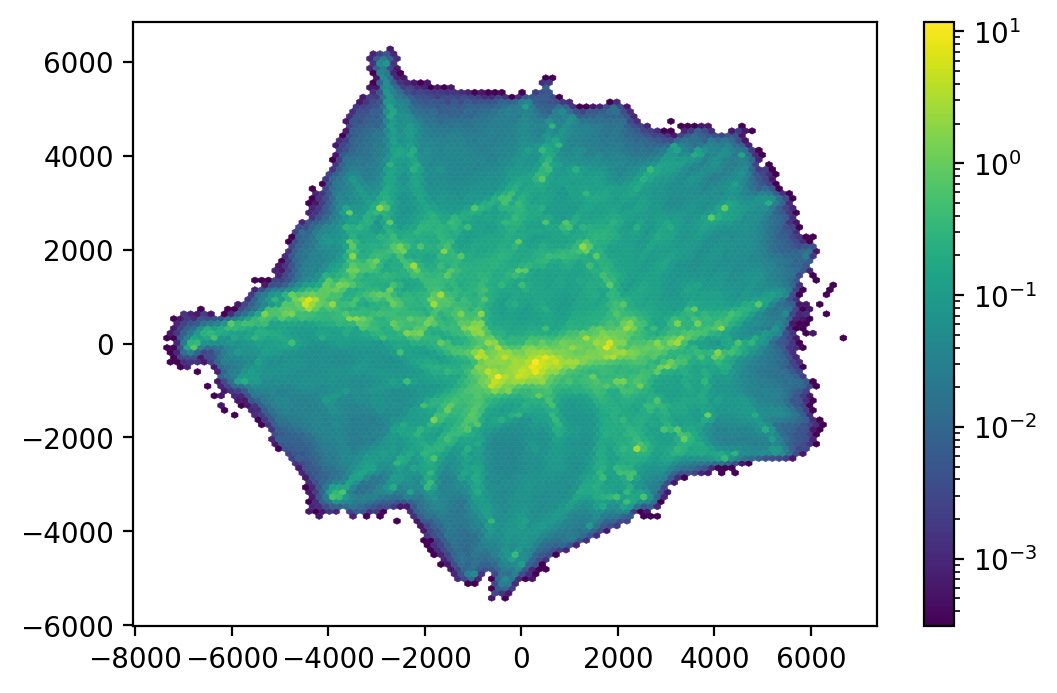

In [8]:
rotated = recentered @ rotation_matrix(np.pi/4, 0, 0)
plt.hexbin(rotated[:,0], rotated[:,1], part_gas["Masses"], reduce_C_function=np.sum, norm=mcm.LogNorm(), linewidth=0.2)
plt.colorbar()

Now let's rotate this around.  We'll use an `ipywidgets.interact` like we did before, but this time we'll also allow for subsetting so that we can see our updates a little faster.

In [9]:
@ipywidgets.interact(phi = (-np.pi, np.pi, 0.01), theta = (-np.pi, np.pi, 0.01), psi = (-np.pi, np.pi, 0.01), subset = [1, 10, 100, 1000])
def make_plot(phi, theta, psi, subset = 1):
    rotated = recentered[::subset] @ rotation_matrix(phi, theta, psi)
    plt.hexbin(rotated[:,0], rotated[:,1], part_gas["Masses"], reduce_C_function=np.sum, norm=mcm.LogNorm(), linewidth=0.2)
    plt.colorbar()

interactive(children=(FloatSlider(value=-0.0015926535897929917, description='phi', max=3.141592653589793, min=…

## ThreeJS

Let's try plotting some of this in pythreejs.

In [10]:
pg = pythreejs.BufferGeometry(
            attributes = dict(
                    position = pythreejs.BufferAttribute(array=recentered, normalized=False),
                    value = pythreejs.BufferAttribute(array=part_gas["Masses"], normalized=False)
            )
)
pm = pythreejs.PointsMaterial()

In [11]:
pp = pythreejs.Points(geometry=pg, material=pm)

In [12]:
pp

Preview(child=Points(geometry=BufferGeometry(attributes={'position': <BufferAttribute shape=(4334546, 3), dtyp…

Doesn't look like much yet, but we can probably fix that!  Let's move our geometry into a scene, so we can control it a bit more.

In [13]:
scene = pythreejs.Scene(children = [pp, pythreejs.AmbientLight(color='#FFFFFF')], background=None)
cam = pythreejs.PerspectiveCamera(position = [0,0,1], up = [1,0,0])
renderer = pythreejs.Renderer(width = 800, height = 800, camera = cam, scene=scene, alpha=True, controls=[pythreejs.OrbitControls(controlling=cam)])
display(renderer)

Renderer(camera=PerspectiveCamera(position=(0.0, 0.0, 1.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.…

So far it doesn't look like much!  But, during the problems section, we'll dig deeper into how we can change this.

For now, let's just satisfy ourselves by making it so that our coordinates are all not only centered, but scaled.  It's a fair bit easier to maneuver pythreejs if the values span roughly unitary.

In [14]:
max_extent = (recentered.max(axis=0) - recentered.min(axis=0)).max()
rescaled = recentered / max_extent

We can update our pythreejs values inline by setting values on the properties.  But, we have to do it in a particular way to make it notice and update our display.  Note that we should *also* probably rescale our sizes, since they're an awful lot bigger (relatively) now!

In [15]:
pg.attributes["position"].array = rescaled
pm.size = 1.0/max_extent

So far this doesn't look like too much -- *still* -- but we will work on that a bit in the problems section.